## 使用监督学习，解决回归问题
监督学习，主要应用于回归和分类两大场景：

| 场景 | 用途 | 示例 |
| :--- | :--- | :--- |
| 回归 | 预测数值 | 计算一个用户使用某产品的过程中消费总量 |
| 分类 | 进行分类判断 | |

> 比如某类手机 App，用户的平均使用长度是两年左右，那么两年内用户在 App 上消费所产生的总收益就是用户的生命周期价值，英文是 Lifetime Value，简称 LTV，
> 有时我们也叫 CLV（Customer Lifetime Value）。

我们的目标就是通过现有数据，找到一个能预测出用户生命周期价值的模型，来指导我们获客的成本，避免超出回报的盲目投入。

## 用户成本与ROI, LTV

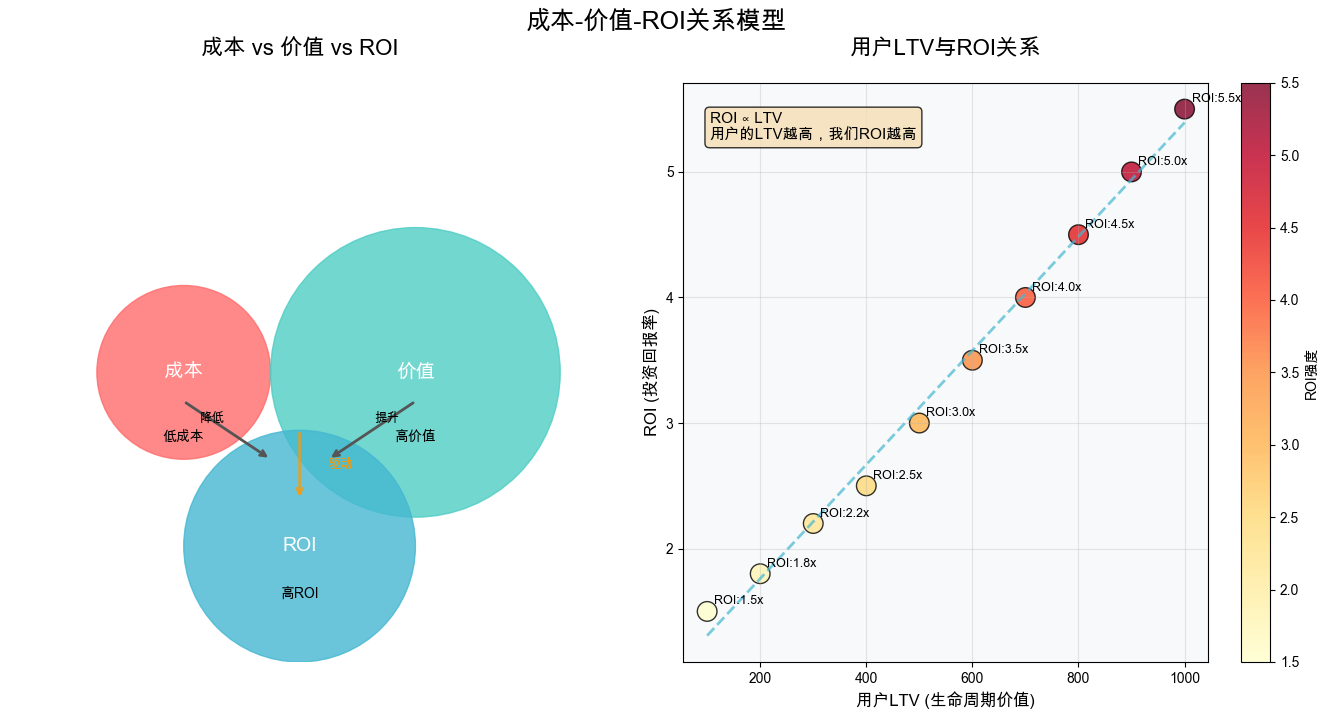

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle, Rectangle
from matplotlib.colors import LinearSegmentedColormap

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# ================== 左边图表：成本、价值、ROI关系 ==================
ax1.set_title('成本 vs 价值 vs ROI', fontsize=16, fontweight='bold', pad=20)

# 创建三个圆表示三个概念
concepts = ['成本', '价值', 'ROI']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
sizes = [30, 50, 40]  # 圆的大小
positions = [(0.3, 0.5), (0.7, 0.5), (0.5, 0.2)]

for i, (concept, color, size, pos) in enumerate(zip(concepts, colors, sizes, positions)):
    circle = Circle(pos, size/200, color=color, alpha=0.8)
    ax1.add_patch(circle)
    ax1.text(pos[0], pos[1], concept, 
             ha='center', va='center', 
             fontsize=14, fontweight='bold',
             color='white')
    
    # 添加说明文字
    if concept == '成本':
        ax1.text(pos[0], pos[1] - 0.1, '低成本', 
                 ha='center', va='top', fontsize=10)
    elif concept == '价值':
        ax1.text(pos[0], pos[1] - 0.1, '高价值', 
                 ha='center', va='top', fontsize=10)
    else:
        ax1.text(pos[0], pos[1] - 0.07, '高ROI', 
                 ha='center', va='top', fontsize=10)

# 添加箭头表示关系
ax1.annotate('', xy=(0.45, 0.35), xytext=(0.3, 0.45),
             arrowprops=dict(arrowstyle='->', color='#555555', lw=2))
ax1.text(0.35, 0.42, '降低', ha='center', va='center', fontsize=9)

ax1.annotate('', xy=(0.55, 0.35), xytext=(0.7, 0.45),
             arrowprops=dict(arrowstyle='->', color='#555555', lw=2))
ax1.text(0.65, 0.42, '提升', ha='center', va='center', fontsize=9)

ax1.annotate('', xy=(0.5, 0.28), xytext=(0.5, 0.4),
             arrowprops=dict(arrowstyle='->', color='#FF9800', lw=2, alpha=0.7))
ax1.text(0.55, 0.34, '驱动', ha='left', va='center', fontsize=9, color='#FF9800')

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal')
ax1.axis('off')

# ================== 右边图表：LTV与ROI关系 ==================
ax2.set_title('用户LTV与ROI关系', fontsize=16, fontweight='bold', pad=20)

# 创建示例数据
ltv_values = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
roi_values = np.array([1.5, 1.8, 2.2, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])

# 绘制散点图
scatter = ax2.scatter(ltv_values, roi_values, c=roi_values, 
                      cmap='YlOrRd', s=200, alpha=0.8, edgecolors='black')

# 绘制趋势线
z = np.polyfit(ltv_values, roi_values, 1)
p = np.poly1d(z)
ax2.plot(ltv_values, p(ltv_values), '--', color='#45B7D1', linewidth=2, alpha=0.7)

# 添加标签
for i, (ltv, roi) in enumerate(zip(ltv_values, roi_values)):
    ax2.annotate(f'ROI:{roi}x', xy=(ltv, roi), xytext=(5, 5),
                textcoords='offset points', fontsize=9)

ax2.set_xlabel('用户LTV (生命周期价值)', fontsize=12, fontweight='bold')
ax2.set_ylabel('ROI (投资回报率)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#f8f9fa')

# 添加公式说明
formula_text = "ROI ∝ LTV\n用户的LTV越高，我们ROI越高"
ax2.text(0.05, 0.95, formula_text, transform=ax2.transAxes,
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 添加颜色条
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('ROI强度', fontsize=10)

# 调整布局
plt.tight_layout()

# 添加总标题
fig.suptitle('成本-价值-ROI关系模型', fontsize=18, fontweight='bold', y=1.02)

plt.show()

## 特征确定
- 用头 3 个月的 R、F、M 这 3 个数值作为特征，也就是回归模型的自变量。而回归模型所要预测的因变量，即数据集的标签，
- 就是一年的总消费额，你可以认为它就是用户的 LTV。
- 数据清洗，这其中包括删除不符合逻辑的负值、查看有没有缺失值、添加每个订单的总价字段等

- 在数据预处理阶段，唯一不同的就是，当前项目需要显示数据集的时间跨度，因为我们要拆分出头3个月的数据作为输入特征，并且只考虑 12 月的总消费金额作为 LTV，所以我们要通过数据集的时间跨度来把它分为两部分，一部分用来构建 RFM 特征（头３个月），另一部分用来构建 LTV 这个标签（整个 1２个月）。

### 整理数据集记录的时间范围

In [13]:
import numpy as np
import pandas as pd
df_sales = pd.read_csv('orders.csv')
df_sales.head()

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


In [14]:
print('日期范围 %s - %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
print('日期范围 %s - %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))

日期范围 1/1/2021 10:11 - 9/9/2020 9:20
日期范围 2020-06-01 09:09:00 - 2021-06-09 12:31:00


In [15]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

日期范围: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


### 构建特征和标签
1. 用前 3 个月的 R、F、M 值作为特征字段
2. 然后把整个 12 个月的消费金额视为 LTV，作为标签字段。

In [16]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据  

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


In [17]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')]
df_sales_3m.reset_index(drop=True)
df_sales_3m.head()

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


In [18]:
df_user_LTV = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user_LTV.columns = ['用户码'] #设定字段名
df_user_LTV.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user_LTV = pd.merge(df_user_LTV, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user_LTV #显示用户表结构

,用户码,R值,F值,M值
0,15100,45,6,635.10
1,15291,35,35,1329.95
2,14688,6,85,1472.28
3,15311,5,718,12730.01
4,15862,89,64,354.23
...,...,...,...,...
365,15951,1,22,375.17
366,14745,1,7,240.60
367,15724,0,5,103.65
368,15874,0,5,584.35


### 构建数据集的标签
> 标签，就是我们需要去预测或者判断的东西。而机器学习，就是通过已知来预测未知，通过训练数据集来寻找规律，发现特征和标签之间的联系。所以，我们下一步要做的，就是把 LTV 值加入到 df_user_LTV 中，这样数据集才完整。我们先根据一整年的数据计算出每一个用户的 LTV 值，也就是 12 个月的总消费金额：


In [19]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index()
df_user_1y.columns = ['用户码','年度LTV']
df_user_1y.head()
df_LTV = pd.merge(df_user_LTV, df_user_1y, on='用户码', how='left')
df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,45,6,635.10,635.10
1,15291,35,35,1329.95,4596.51
2,14688,6,85,1472.28,4470.65
3,15311,5,718,12730.01,58352.77
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
365,15951,1,22,375.17,375.17
366,14745,1,7,240.60,1167.16
367,15724,0,5,103.65,212.30
368,15874,0,5,584.35,4330.67


### 创建特征集和标签集

> 刚刚我们把特征和标签整合在一起，是为了形成完整的数据集。不过，标签集和特征集要分别输入机器学习模型，所以要分别创建。

#### 构建特征集

In [20]:
X = df_LTV.drop(['用户码','年度LTV'], axis=1)
X.head()

,R值,F值,M值
0,45,6,635.10
1,35,35,1329.95
2,6,85,1472.28
3,5,718,12730.01
4,89,64,354.23


### 构建标签集

In [21]:
y = df_LTV['年度LTV']
y.head()

0      635.10
1     4596.51
2     4470.65
3    58352.77
4      659.73
Name: 年度LTV, dtype: float64

## 拆分训练集、验证集和测试集

> 用 scikit-learn 工具包中的拆分工具 train_test_split，进行拆分

In [22]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=36)
# 再把其它集拆分成验证集和测试集
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=36)

最后，我们得到的数据集
- X_train、X_valid 和 X_test 的字段，与 X 中的字段还是一样
- y_train、y_valid、y_test 中的字段和 y 的也一样，只是它们的行数发生了改变：

- X_train 是 288 行×4 列；
- y_train 是 288 行×1 列；
- _valid 是 73 行×4 列；
- y_valid 是 73 行×1 列；
- X_test 是 73 行×4 列；
- y_test 是 73 行×1 列。

## 选择算法创建模型

> 因为这是一个回归问题，所以，在模型类型的选择方面，我们肯定使用的是回归算法。这是基于问题本身的性质而确定的，毋庸置疑。



| 算法名称 | 说明 |
|-------|-------|
| 线性回归 | 利用线性回归方程的最小二乘函数，对一个或多个自变量和因变量之间的关系，进行建模的一种回归分析。 |
| 贝叶斯回归 | 使用统计学中贝叶斯推断（Bayesian inference）方法求解的线性回归（linear regression）模型。 |
| SVM回归（SVR） | 通过SVM解决回归问题，就是找到一个回归平面，让一个集合的所有数据到该平面的距离最近。 |
| 决策树 | 主要指CART(classification and regression tree)算法，内部结点特征的取值为"是"和"否"，为二叉树结构。用决策树解决回归问题，就是根据特征向量来决定对应的输出值。 |
| 随机森林 | 用多棵决策树组合而成的一种集成学习模型。 |
| AdaBoost和XGBoost等梯度提升算法 | 利用Boosting方法基于树模型建立的集成学习模型。 |
| 神经网络算法 |	由一组相互连接的神经元构建出来的深度学习模型。|

![替代文本](%E5%86%B3%E7%AD%96%E6%A0%91.png "决策树")


## 导入并创建线性回归模型、决策树模型和随机森林模型。

In [ ]:
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
from sklearn.ensemble import RandomForestRegressor #导入随机森林回归模型
model_lr = LinearRegression() #创建线性回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_rfr = RandomForestRegressor() #创建随机森林回归模型


## 训练模型

In [24]:
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_rfr.fit(X_train, y_train) #拟合随机森林模型

RandomForestRegressor()

## 评估模型


In [25]:
y_valid_preds_lr = model_lr.predict(X_valid) #用线性回归模型预测验证集
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_rfr = model_rfr.predict(X_valid) #用随机森林模型预测验证集

In [26]:
X_valid.iloc[2] #随便选择一个数据

R值       1.00
F值     154.00
M值    1427.73
Name: 163, dtype: float64

In [27]:
print('真值:', y_valid.iloc[2])  #真值
print('线性回归预测值:', y_valid_preds_lr[2])  #线性回归模型预测值
print('决策树预测值:', y_valid_preds_dtr[2])  #决策树模型预测值
print('随机森林预测值:', y_valid_preds_rfr[2]) #随机森林模型预测值

真值: 4432.43
线性回归预测值: 7474.418142488348
决策树预测值: 2247.51
随机森林预测值: 4550.4960000000065


In [28]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('验证集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的R平方分数-随机森林: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

验证集上的R平方分数-线性回归: 0.4410
验证集上的R平方分数-决策树: 0.2854
验证集上的R平方分数-随机森林: 0.5252


Text(0.5, 1.0, '实际值 vs. 预测值')

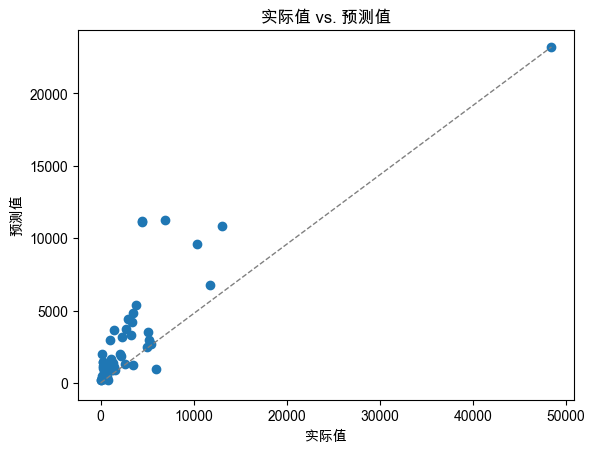

In [31]:
y_test_preds_rfr = model_rfr.predict(X_test) #用模型预随机森林模型预测验证集
plt.scatter(y_test, y_test_preds_rfr) #预测值和实际值的散点图
plt.plot([0, max(y_test)], [0, max(y_test_preds_rfr)],   color='gray', lw=1, linestyle='--') #绘图
plt.xlabel('实际值') #X轴
plt.ylabel('预测值') #Y轴
plt.title('实际值 vs. 预测值') #标题